<a id='head'></a>
# Table of Contents
* [0. General classes](#funcs)
    * [0.0 imports](#imports)
    * [0.1 Checker & printer](#check&print)
    * [0.2 Distribution calculator](#distr_calc)
    * [0.3 Solver](#solver)
* [1. Simulation model](#sim)
    * [1.2 PLR calculator for simulation model](#sim_prl_ana)
* [2. Math models](#anas)
    * [2.1 $(h,m)$ math model](#hm_ana)
        * [2.1.1 Base $(h, m)$ ana](#base_hm_ana)
        * [2.1.2 Dynamic $(h, m)$ ana](#dyn_hm_ana)
            * [2.1.2.1 PLR calculator for dynamic $(h,m)$ model](#dyn_prl_hm_ana)
    * [2.2 $(h,m,n)$ math model](#ana_hmn)
    * [2.3 Tracer](#tracer)
        * [2.3.1 Base tracer](#base_tracer)
            * [2.3.1.1 PLR calculator for base tracer](#plr_base_tracer)
        * [2.3.2 Dynamic tracer](#dyn_tracer)
            * [2.3.2.1 PLR calculator for dynamic tracer](#plr_dyn_tracer)
    * [2.4 Testing](#testing)
        * [2.4.1 CBR](#test_cbr)
        * [2.4.2 VBR](#test_vbr)
        * [2.4.3 Trace](#test_trace)
* [3. Tracing](#tracing)
    * [3.1 South](#tracing_south)
    * [3.2 Casino](#tracing_casino)

<a id='funcs'></a>
# 0. General classes<sup>[head](#head)</sup>

<a id='imports'></a>
## 0.0 imports<sup>[head](#head)</sup>

In [3]:
import numpy as np
import pandas as pd

import random
import math
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as rc

import subprocess
import sys, os, argparse
import pickle as pkl
import copy
import numbers

from collections import Counter, defaultdict
from itertools import product
from math import gcd
from ast import literal_eval

import logging
import time


# Распределения
from scipy.stats import binom, geom, poisson
from scipy import sparse
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import spsolve, bicgstab, eigs, svds, ArpackNoConvergence
from scipy.sparse.csgraph import connected_components

import importlib
from numpy.fft import fft, ifft

# Распараллеливание
import ctypes
import multiprocessing as mp

PLR_CALCULATORS = {}

<a id='check&print'></a>
## 0.1 Checker & printer<sup>[head](#head)</sup>

In [4]:
class Printer:
    def __init__(self, verbose, owner):
        """
        Класс, ответственный за распечатку сообщений. 
        Печатает сообщение, когда его уровень печати превосходит уноверь печати
        объекта класса.
        """
        self.verbose = verbose
        self.owner = owner
    def __call__(self, *args, **kwargs):
        if self.owner.verbose >= self.verbose:
            print(*args, **kwargs)


class Checker(Printer):
    def __init__(self):
        self.printers = {}
        for v in range(20):
            self.printers[v] = Printer(v, self) 
            
    def _check_numeric(self, n, name):
        if not isinstance(n, numbers.Number):
            raise TypeError("Param \"{}\" must be a number".format(name))
        return True 
    def _check_int(self, n, name):
        self._check_numeric(n, name)
        if not n == int(n):
            raise TypeError("Param \"{}\" must be an integer number".format(name))
        return True
    def _check_positive(self, n, name):
        self._check_numeric(n, name)
        if n <= 0:
            raise ValueError("Param \"{}\" must be positive".format(name))
        return True
    def _check_nonnegative(self, n, name):
        self._check_numeric(n, name)
        if n < 0:
            raise ValueError("Param \"{}\" must be nonegative".format(name))
        return True   
    def _check_proba(self, n, name):
        self._check_numeric(n, name)
        if (n <= 1) & (n >= 0):
            return True
        raise ValueError("Param \"{}\" is not proba though it must be".format(name))
    def _check_distr(self, distr, name):
        for i in range(len(distr)):
            self._check_proba(distr[i], name + '[{}]'.format(i))
        if not np.allclose(np.sum(distr), 1):
            raise ValueError("Distribution \"{}\" is not normed: sum equals {}".format(name, np.sum(distr)))
        return True

<a id='distr_calc'></a>
## 0.2 Distribution calculator<sup>[head](#head)</sup>

In [5]:
class DistributionCalculator(Checker):
    def __init__(self, alpha):
        self.alpha = alpha
        self._check_proba(alpha, 'alpha')
        
    def get_distr1(self, trace):
        if len(trace) < 1:
            raise ValueError("Trace length must be at least 1")
        trace = np.array(trace)[::-1]
        weights = self.alpha ** np.arange(len(trace))
        input_distr = np.zeros(np.max(trace) + 1)
        for i, batch_size in enumerate(trace):
            input_distr[batch_size] += weights[i]
        input_distr /= np.sum(input_distr) 
        
        new_input_distr = {}
        for batch_size, prob in enumerate(input_distr):
            if prob > 0:
                new_input_distr[batch_size] = prob
        return new_input_distr
    
    def get_distr2(self, trace):
        if len(trace) < 1:
            raise ValueError("Trace length must be at least 1")
        trace = np.array(trace)[::-1]
        input_distr = {}
        weight = 1.0
        for n_pair, pair in enumerate(zip(trace, trace[1:])):
            second, first = pair
            distr = input_distr.setdefault(first, {})
            distr.setdefault(second, 0)
            distr[second] += weight
            weight *= self.alpha
            if weight < 1e-6:
                break
        for first in input_distr:
            s = sum(input_distr[first].values())
            for second in input_distr[first]:
                input_distr[first][second] /= s
        for first in input_distr:
            for second in input_distr:
                assert second in input_distr
        
        assert trace[0] in input_distr # из последней пачки должен быть переход
        return input_distr

<a id='solver'></a>
## 0.3 Solver<sup>[head](#head)</sup>

In [4]:
def find_stationary_distribution(P, max_error=1e-9, iterative=False, multiplier=1000):
    assert (len(P.shape) == 2) & (P.shape[0] == P.shape[1])

    size = P.shape[0]
    P = P.tocoo()
    P = (P - sparse.eye(size)).transpose().tocsr()

    selected_column = random.randrange(size)
    upper_P = P[:selected_column]
    lower_P = P[selected_column + 1:]
    row = sparse.csr_matrix(np.ones(size))
    if selected_column == 0:
        P = sparse.vstack([row, lower_P])
    elif selected_column == size - 1:
        P = sparse.vstack([upper_P, row])
    else:
        P = sparse.vstack([upper_P, row, lower_P])

    b = np.zeros(size)
    b[selected_column] = multiplier
    P = P.tocsr()
    if iterative:
        x0 = np.array([multiplier / size] * size)       # Нулевое приближение
        x = bicgstab(P, b, x0=x0, tol=1e-10, maxiter=4000)[0]
    else:
        x = spsolve(P, b)
    x /= multiplier
    return x

<a id='sim'></a>
# 1. Simulation model<sup>[head](#head)</sup>

In [5]:
class SimulationModel(Checker):
    def _write_input_file(self):
        file = open(self.input_file, 'w')
        for key, value in self.parameters.items():
            file.write(key + ' ' + str(value) + '\n')
        file.close()
    def _write_trace_file(self):
        file = open(self.trace_file, 'w')
        for batch_size in self.trace:
            file.write(str(int(batch_size)) +'\n')
        file.close()
        
    def __init__(self, parameters):
        self.parameters = copy.copy(parameters)
        self.trace = self.parameters['trace']
        self.input_file = self.parameters.setdefault('input_file', 'input.txt')
        self.trace_file = self.parameters.setdefault('trace_file', 'trace.txt')
        self.model_file = self.parameters.setdefault('model_file', './imm_dynamic')
        self.parameters['batchfile_path'] = self.trace_file
        
        del self.parameters['trace']
        del self.parameters['trace_file']
        del self.parameters['input_file']
        del self.parameters['model_file']
        
    def __call__(self, window_size, return_params=False):
        self.parameters['window_size'] = window_size
        self._write_input_file()
        self._write_trace_file()
        assert os.path.isfile(self.model_file)
        assert os.path.isfile(self.input_file)
        assert os.path.isfile(self.trace_file)
         
        args = [self.input_file]
        output = subprocess.check_output([self.model_file] + args)
        output = output.decode('utf8').split('\n')
        args_dict = {}
        for i in range(len(output)):
            if len(output[i].split()) != 2:
                continue
            key, value = output[i].split()
            if key in ['seed', 'res_period', 'arr_period', 'delay_bound', 'window_size', 'max_batch_size',
                       'random_on', 'h_init', 'm_init', 'n_init']:
                args_dict[key] = int(float(value))
            elif key in ['batchfile_path']:
                args_dict[key] = value
            elif key in ['det_per', 'ran_per', 'rand_tx_duration', 'det_tx_duration', 'mean_access_time', 'PLR']:
                args_dict[key] = float(value)
        
        if not return_params:
            return args_dict['PLR']
        return args_dict['PLR'], args_dict

<a id='sim_prl_ana'></a>
### 1.2 PLR calculator for simulation model<sup>[head](#head)</sup>

In [6]:
class SimPlrCalculator:
    def __init__(self, parameters, window_size, n_runs, return_params=False, **kwargs):
        self.parameters = copy.copy(parameters)
        self.window_size = window_size
        self.n_runs = n_runs
        self.return_params = return_params
    def __call__(self, res_period):
        self.res_period = res_period
        self.parameters['res_period'] = res_period
        sim_plr = 0
        for n_run in range(self.n_runs):
            self.parameters['seed'] = n_run
            self.sim_model = SimulationModel(self.parameters)
            plr, sim_output = self.sim_model(self.window_size, return_params=True)
            sim_plr += plr
        sim_plr /= self.n_runs
        self.plr = sim_plr
        if self.return_params:
            return self.plr, sim_output
        return self.plr
    
PLR_CALCULATORS['SIM'] = SimPlrCalculator

<a id='anas'></a>
# 2. Math models<sup>[head](#head)</sup>

<a id='hm_ana'></a>
## 2.1 $(h,m)$ math model<sup>[head](#head)</sup>

<a id='base_hm_ana'></a>
### 2.1.1 Base $(h,m)$ model<sup>[head](#head)</sup>

In [7]:
class BurstyVbrOrderedModel(Checker):
    def __init__(self, parameters):
        self.initialize(parameters)

    def set_input_distr(self, input_distr):
        if isinstance(input_distr, tuple([np.ndarray, list])):
            self.input_distr = np.array(input_distr)
        elif isinstance(input_distr, dict):
            max_batch_size = max(input_distr.keys())
            self.input_distr = np.zeros(max_batch_size + 1)
            for batch_size, prob in input_distr.items():
                self.input_distr[batch_size] = prob
        assert self.input_distr[0] == 0
        self._check_distr(self.input_distr, 'input_distr')
        
    def initialize(self, parameters):
        self.parameters  = copy.deepcopy(parameters)
        self.arr_period  = self.parameters['arr_period']
        self.set_input_distr(self.parameters['input_distr'])
        self.res_period  = self.parameters['res_period']
        self.block_size  = self.parameters['block_size']
        self.delay_bound = self.parameters['delay_bound']
        self.per         = self.parameters['per']
        self.max_error  = self.parameters.setdefault('max_error', 1e-9)
        self.iterative  = self.parameters.setdefault('iterative', False)
        self.check_time = self.parameters.setdefault('check_time', False)
        
    def __call__(self):
        slot = gcd(self.arr_period, self.res_period)
        tres = self.res_period // slot
        tin = self.arr_period // slot
        d = self.delay_bound // slot
        M = len(self.input_distr) - 1
        size = (d + tin + 1) * M
        forward_transform = lambda h, m: (h + tin) * M + m - 1

        ###################################################################
        # Нахождение матрицы A
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []
        
        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                initial_state = forward_transform(initial_h, initial_m)
                if initial_h < 0:
                    final_h = initial_h
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(1, initial_state, final_state)
                else:
                    # Неуспешная передача
                    final_h = initial_h
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(self.per, initial_state, final_state)

                    if initial_m == 1:
                        # Успешная передача при m = 1
                        final_h = initial_h - tin
                        for final_m in range(1, M + 1):
                            final_state = forward_transform(final_h, final_m)
                            self._add_transition((1 - self.per) * self.input_distr[final_m],
                                                 initial_state, final_state)
                    else:
                        # Успешная передача при m > 1
                        final_h = initial_h
                        final_m = initial_m - 1
                        final_state = forward_transform(final_h, final_m)
                        self._add_transition(1 - self.per, initial_state, final_state)

        A = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))

        # Нахождение матрицы C
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []

        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                initial_state = forward_transform(initial_h, initial_m)
                if initial_h <= d - tres:
                    final_h = initial_h + tres
                    final_m = initial_m
                    final_state = forward_transform(final_h, final_m)
                    self._add_transition(1, initial_state, final_state)
                else:
                    n_lost = np.ceil(1.0 * max(0, initial_h + tres - tin - d) / tin)
                    final_h = initial_h + tres - tin - n_lost * tin
                    for final_m in range(1, M + 1):
                        final_state = forward_transform(final_h, final_m)
                        self._add_transition(self.input_distr[final_m],
                                             initial_state, final_state)

        C = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))
        A = A ** self.block_size
        P = C * A
        ###################################################################
        x = find_stationary_distribution(P, max_error=self.max_error, iterative=self.iterative, multiplier=1000)
        self.x = x
        ###################################################################

        discarded_intensity = 0
        average_input_batch_size = np.sum(np.arange(M + 1) * self.input_distr)
        for h in range(d - tres + 1, d + 1):
            for m in range(1, M + 1):
                state = forward_transform(h, m)
                n_lost = np.ceil(float(max(0, h + tres - tin - d)) / tin)
                discarded_intensity += x[state] * (m + n_lost * average_input_batch_size)
        discarded_intensity /= tres
        input_intensity = average_input_batch_size / tin
        self.plr = discarded_intensity / input_intensity
        return self.plr

    def _add_transition(self, probability, initial_state, final_state):
        if final_state != self.selected_column:
            if probability > 0:
                self.nonzeros.append(probability)
                self.row_indices.append(initial_state)
                self.col_indices.append(final_state)
            assert probability >= 0, "Negative probability"

<a id='dyn_hm_ana'></a>
### 2.1.2 Dynamic $(h,m)$ model<sup>[head](#head)</sup>

In [8]:
class DynamicHmModel:
    def __init__(self, parameters, distr_calculator=DistributionCalculator(1.0)):
        self.parameters = copy.copy(parameters)
        self.distr_calculator = distr_calculator
        
        self.trace = self.parameters['trace']
        self.arr_period = self.parameters['arr_period']
        
        self._initial_state()
        self.parameters['trace'] = self.known_trace
        self.parameters['block_size'] = 1
        self.parameters['input_distr'] = self.input_distr
        self.model = BurstyVbrOrderedModel(self.parameters)

    def _initial_state(self):
        assert isinstance(trace, np.ndarray), "Trace must be an array"
        self.initial_state = (self.parameters['h_init'], self.parameters['m_init'], self.parameters['n_init'])
        h_init, m_init, n_init = self.initial_state 
        max_known_n = -1
        if h_init >= 0:
            # Есть пачки в очереди. Выясним, до какого номера известен трейс
            max_known_n = n_init # Это индекс
            h = h_init
            h -= self.arr_period
            while h >= 0:
                max_known_n += 1
                h -= self.arr_period
        else:
            max_known_n = n_init - 1 # Известно все до текущей пачки
            assert max_known_n >= 0
        assert max_known_n < len(self.trace)        
        self.known_trace = self.trace[:max_known_n + 1]
        assert len(self.known_trace) > 0
        self.input_distr = self.distr_calculator.get_distr1(self.known_trace)
        
    def __call__(self):
        return self.model()

<a id='dyn_prl_hm_ana'></a>
#### 2.1.2.1 PLR calculator for dynamic $(h,m)$ model<sup>[head](#head)</sup>

In [9]:
class DynHmPlrCalculator:
    def __init__(self, parameters, alpha, *args, **kwargs):
        self.parameters = copy.copy(parameters)
        self.alpha = alpha
    def __call__(self, res_period):
        self.res_period = res_period
        self.parameters['res_period'] = res_period
        self.model = DynamicHmModel(self.parameters, distr_calculator=DistributionCalculator(self.alpha))
        self.plr = self.model()
        return self.plr

PLR_CALCULATORS['DYN_HM'] = DynHmPlrCalculator

<a id='ana_hmn'></a>
## 2.2 $(h,m,n)$ math model<sup>[head](#head)</sup>

In [10]:
class BurstyVbrOrderedModel_hmn:
    string_id = 'TXOP'
    number_id = -1
    
    def __init__(self, parameters):
        self.initialize(parameters)
    
    def initialize(self, parameters):
        self.parameters  = copy.copy(parameters)
        
        self.model_type  = self.parameters['model_type']
        self.arr_period  = self.parameters['arr_period']
        self.input_distr = copy.deepcopy(self.parameters['input_distr'])
        self.res_period  = self.parameters['res_period']
        self.block_size  = self.parameters['block_size']
        self.delay_bound = self.parameters['delay_bound']
        self.per         = self.parameters['per']
        self.cond_probs  = self.parameters['cond_probs']
        
        if 'seed' not in parameters:
            self.parameters['seed'] = 1
        if 'output_flow' not in parameters:
            self.parameters['output_flow'] = False

        if 'max_error' not in parameters:
            self.parameters['max_error'] = 1e-9
        if 'iterative' not in parameters:
            self.parameters['iterative'] = False
            
        if 'check_time' not in parameters:
            self.parameters['check_time'] = False
            
        self.seed = self.parameters['seed']
        self.output_flow = self.parameters['output_flow']
        
        self.max_error = self.parameters['max_error']
        self.iterative = self.parameters['iterative']
        
        self.check_time = self.parameters['check_time']
        
    def __call__(self, dim=3):
        slot = gcd(self.arr_period, self.res_period)
        tres = self.res_period // slot
        tin = self.arr_period // slot
        d = self.delay_bound // slot
        input_probs = self.input_distr
        cond_probs = self.cond_probs
        M = len(input_probs) - 1
        batch_sizes = np.array(range(M + 1))
        if dim == 3:               
            size = (d + tin + 1) * M ** 2
            forward_transform = lambda h, m, n: (h + tin) * M ** 2 + (m - 1) * M + n - 1                
        elif dim == 2:
            size = (d + tin + 1) * M                                         
            forward_transform = lambda h, m, n: (h + tin) * M + m - 1 + 0 * n
        else:
            assert False
        ###################################################################
        
        start = time.clock()
        
        # Нахождение матрицы A
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []
        
        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                for initial_n in range(1, M + 1):
                    initial_state = forward_transform(initial_h, initial_m, initial_n)
                    if initial_h < 0:
                        final_h = initial_h                                                   
                        final_m = initial_m                                                         
                        final_n = initial_n
                        final_state = forward_transform(final_h, final_m, final_n)
                        self._add_transition(1, initial_state, final_state)
                    else:
                        # Неуспешная передача
                        final_h = initial_h
                        final_m = initial_m
                        final_n = initial_n
                        final_state = forward_transform(final_h, final_m, final_n)
                        self._add_transition(self.per, initial_state, final_state)
                        
                        if initial_m == 1:
                            # Успешная передача при m = 1
                            final_h = initial_h - tin
                            for final_m in range(1, M + 1):
                                final_n = final_m
                                final_state = forward_transform(final_h, final_m, final_n)
                                self._add_transition((1 - self.per) * cond_probs[initial_n, final_n],
                                                     initial_state, final_state)
                        else:
                            # Успешная передача при m > 1
                            final_h = initial_h
                            final_m = initial_m - 1
                            final_n = initial_n
                            final_state = forward_transform(final_h, final_m, final_n)
                            self._add_transition(1 - self.per, initial_state, final_state)
        
        A = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))
        
        # Нахождение матрицы C
        self.selected_column = -1
        self.nonzeros = []
        self.row_indices = []
        self.col_indices = []
        for initial_h in range(-tin, d + 1):
            for initial_m in range(1, M + 1):
                for initial_n in range(1, M + 1):
                    initial_state = forward_transform(initial_h, initial_m, initial_n)
                    if initial_h <= d - tres:
                        final_h = initial_h + tres
                        final_m = initial_m
                        final_n = initial_n
                        final_state = forward_transform(final_h, final_m, final_n)
                        self._add_transition(1, initial_state, final_state)
                    else:
                        n_lost = np.ceil(1.0 * max(0, initial_h + tres - tin - d) / tin)
                        assert n_lost == 0
                        final_h = initial_h + tres - tin - n_lost * tin
                        for final_m in range(1, M + 1):
                            final_n = final_m
                            final_state = forward_transform(final_h, final_m, final_n)
                            self._add_transition(cond_probs[initial_n , final_n],
                                                 initial_state, final_state)

        C = sparse.csr_matrix((self.nonzeros, (self.row_indices, self.col_indices)),
                              shape=(size, size))
        
        if dim == 2:
            A = A / M
            C = C / M
        
        A = A ** self.block_size
        P = C * A

        end = time.clock()
        if self.check_time:
            print('Time: building transition matrix:', end - start)
            
        ###################################################################
        
        start = time.clock()
        x = find_stationary_distribution(P, max_error=1e-9, iterative=False, multiplier=1000)
        self.x = x
        #print(x)
        end = time.clock()
        if self.check_time:
            print('Time: seeking for stationary distributions:', end - start)
        
        ###################################################################
        
        discarded_intensity = 0
        average_input_batch_size = np.sum(np.arange(M + 1) * input_probs)
        for h in range(d - tres + 1, d + 1):
            for m in range(1, M + 1):
                for n in range(1, M + 1):
                    state = forward_transform(h, m, n)
                    n_lost = np.ceil(float(max(0, h + tres - tin - d)) / tin)
                    assert n_lost == 0
                    discarded_intensity += x[state] * (m + n_lost * average_input_batch_size)    
        discarded_intensity /= tres
        input_intensity = average_input_batch_size / tin
        self.plr = discarded_intensity / input_intensity
        
        
        return self.plr
        
    def _add_transition(self, probability, initial_state, final_state):
        if final_state != self.selected_column:
            if probability > 0:
                self.nonzeros.append(probability)
                self.row_indices.append(initial_state)
                self.col_indices.append(final_state)
            assert probability >= 0, "Negative probability"

In [10]:
        """
        Внимание:
        Изначально окно W начинается в момент времени 0, в котором также начинается некоторый зарезерированный 
        интервал. При повторных запусках окно W отсчитывается с резервирования, на котором 
        остановились предшествующие вычисления. Начальные offset-ыможно моделировать задав соответствующие
        problist и lostlist.
        
        Просчитываются все резервирования, начинающиеся в интервале[0, W]. 
        Если резервироваание начинается далее, то оно не рассматривается. Последующие 
        вычисления начинаются именно с него.
        
        При подсчете PLR число полученных пачек считается от 0-го момента, т.е. те, 
        что уже были в очереди, не в счет
        
        :param W - размер окна в тех же единицах, что и Tin, Tres
        :type W - int, float
        
        :param trace - трейс размеров пачек
        :type trace - numpy.array
        
        :param problist - вероятности начальных состояний
        :type problist - dict
        
        :param lostlist - потери начальных состояний
        :type lostlist - dict
        
        :param statesarrived - число поступивших пакетов
        :type statesarrived - dict
        
        :param input_distr - распределение пачек входного потока
        :type input_distr - numpy.array размера M + 1, где M - максимальный размер пачки

        :param verbose - уровень печати вспомогательных сообщений
        :type verbose - int
        
        :param report_period - период печати статистики
        :type reprot_period - int
        """
    
        """
        :param Tin - период поступления
        :type Tin - int
        
        :param Tres - период резервирования
        :type Tin - int
        
        :param D - delay bound
        :type D - int
        
        :param PER - вероятность ошибки
        :type PER - float
        """

'\nВнимание:\nИзначально окно W начинается в момент времени 0, в котором также начинается некоторый зарезерированный \nинтервал. При повторных запусках окно W отсчитывается с резервирования, на котором \nостановились предшествующие вычисления. Начальные offset-ыможно моделировать задав соответствующие\nproblist и lostlist.\n\nПросчитываются все резервирования, начинающиеся в интервале[0, W]. \nЕсли резервироваание начинается далее, то оно не рассматривается. Последующие \nвычисления начинаются именно с него.\n\nПри подсчете PLR число полученных пачек считается от 0-го момента, т.е. те, \nчто уже были в очереди, не в счет\n\n:param W - размер окна в тех же единицах, что и Tin, Tres\n:type W - int, float\n\n:param trace - трейс размеров пачек\n:type trace - numpy.array\n\n:param problist - вероятности начальных состояний\n:type problist - dict\n\n:param lostlist - потери начальных состояний\n:type lostlist - dict\n\n:param statesarrived - число поступивших пакетов\n:type statesarrived - 

<a id='tracer'></a>
## 2.3 Tracer<sup>[head](#head)</sup>

<a id='base_tracer'></a>
### 2.3.1 Base tracer<sup>[head](#head)</sup>

In [11]:
class BaseTracer(Checker):
    TR_INFO_0 = 4
    TR_INFO_1 = 5
    TR_INFO_2 = 6
    TR_INFO_3 = 7
    
    TRACE_CONTINUES = 0
    TRACE_DIST1 = 1
    TRACE_DIST2 = 2
    TRACE_FINISHED = 3
    
    def next_batch_states(self, state, type_of_distr=self.TRACE_DIST1):
        next_states_dict = {}
        r, h, m, n = state
        if r == self.TRACE_CONTINUES: #в этом состоянии trace известен
            next_n = n + 1
            if next_n >= len(self.trace): # Переходный момент
                if self.input_distr is None:
                    # Переход в финальное состояние
                    next_states_dict[(self.TRACE_FINISHED, 0, next_n)] = 1.0
                else:
                    if type_of_distr == seld.TRACE_DIST1:
                        for batch_size, prob in self.input_distr.items():
                            next_states_dict[(type_of_distr, batch_size, -1)] = prob
                    else:
                        assert type_of_distr == seld.TRACE_DIST2
                        for batch_size, prob in self.input_distr[self.trace[len(self.trace)]].items():
                            next_states_dict[(type_of_distr, batch_size, -1)] = prob
            else:
                next_states_dict[(self.TRACE_CONTINUES, self.trace[next_n], next_n)] = 1.0
            return next_states_dict
        
        if r == self.TRACE_DIST1: #дальше по распределению одномерному
            for batch_size, prob in self.input_distr.items():
                next_states_dict[(self.TRACE_DIST1, batch_size, -1)] = prob
            return next_states_dict
        
        if r == self.TRACE_DIST2: #или двумерному
            for batch_size, prob in self.input_distr[n].items():
                next_states_dict[(self.TRACE_DIST2, batch_size, -1)] = prob
            return next_states_dict
        
        if r == self.TRACE_FINISHED: #всё передалось
            next_states_dict[(self.TRACE_FINISHED, 0, n)] = 1.0
            return next_states_dict

        assert False, 'Pain!'
            
    
    def __init__(self, parameters):
        self.parameters = copy.deepcopy(parameters) # Массив тоже копируется
        self.trace = self.parameters['trace']
        self.Tin = self.parameters['arr_period']
        self.D = self.parameters['delay_bound']
        self.Tres = self.parameters['res_period']
        self.PER = self.parameters['per']
        self.input_distr = self.parameters['input_distr']
        self.n_res = 0
        
        self._check_numeric(Tin, 'Tin')
        self._check_numeric(Tres, 'Tres')
        self._check_numeric(D, 'D')

        self._check_int(Tin, 'Tin')
        self._check_int(D, 'D')
        self._check_int(Tres, 'Tres')
        
        self._check_positive(Tin, 'Tin')
        self._check_positive(Tres, 'Tres')
        self._check_positive(D, 'D')
        
        self._check_numeric(PER, 'PER')
        self._check_proba(PER, 'PER')
       
        self.initialized = False
        """if auto_initialize:
            # Инициализация
            if len(self.trace) > 0:
                assert self.trace[0] >= 1
                statesprob_init = {(self.TRACE_CONTINUES, 0, self.trace[0], 0): 1.0}
            else:
                assert self.input_distr is not None, 'Senseless parameters'
                assert np.allclose(sum(self.input_distr.values()))
                statesprob_init = {(self.TRACE_DIST1, 0, batch_size, -1): 1.0 
                                   for batch_size, prob in self.input_distr}
            self.reset(statesprob_init)"""
          
    def set_res_period(self, Tres):
        self._check_numeric(Tres, 'Tres')
        self._check_int(Tres, 'Tres')
        self._check_positive(Tres, 'Tres')     
        self.Tres = Tres
        
    def reset(self,
              statesprob_init, 
              stateslost_init=None, 
              statesarrived_init=None):

        assert isinstance(statesprob_init, dict)
        assert np.allclose(sum(statesprob_init.values()), 1.0)
        if (stateslost_init is not None) & (stateslost_init is not None):
            assert set(statesprob_init.keys()) == set(stateslost_init.keys())
            assert set(statesprob_init.keys()) == set(statesarrived_init.keys())
        elif (stateslost_init is None) & (statesarrived_init is None):
            stateslost_init = Counter()
            statearrived_init = Counter()
            for state in statesprob_init:
                stateslost_init[state] = 0
                statearrived_init[state] = 0
        else:
            assert False

        self.statesprob = Counter() 
        self.statesprob.update(statesprob_init)
        self.statesprob_init = copy.deepcopy(statesprob_init)
        
        self.stateslost = Counter()
        self.stateslost.update(stateslost_init)
        self.stateslost_init = copy.deepcopy(stateslost_init)
        
        self.statesarrived = Counter()
        self.statesarrived.update(statesarrived_init)
        self.statesarrived_init = copy.deepcopy(statesarrived_init)
        self.n_iters = 0
        self.initialized = True
    
    def __call__(self, W, min_tracked_proba=1e-8, verbose=-1, report_period=10000000, time_verbose=False):
        assert self.initialized
        self.verbose = verbose
        self.min_tracked_proba = min_tracked_proba
        Nres = int(float(W) / self.Tres) + 1
  
        from tqdm import tqdm
        generator = range(Nres)
        if time_verbose:
            generator = tqdm(generator)
            
        for nres in generator:
            self.n_iters += 1
            self.n_res += 1
            if (self.n_iters + 1) % report_period == 0:
                plr = self.get_plr(throw=False)
                
            self.next_statesprob = Counter()
            self.next_stateslost = Counter()
            self.next_statesarrived = Counter()
            
            for state, prob in self.statesprob.items():
                losts = self.stateslost[state]
                arrived = self.statesarrived[state]
                r, h, m, n = state
                
                if r == self.TRACE_FINISHED:
                    # Достигнуто финальное состояние, так как трейс закончился. Остаемся в том же состоянии.
                    self._add_proba(state, state, 1.0, losts, arrived)
                    continue
                if h < 0:
                    next_state = (r, h + self.Tres, m, n)
                    self._add_proba(state, next_state, 1.0, losts, arrived)
                elif h <= self.D - self.Tres:
                    # Успешная передача
                    if m == 1:
                        # Размер пачки равен 1 - смена пачки
                        next_h = h + self.Tres - self.Tin
                        for (next_r, next_m, next_n), prob in self.next_batch_states(state).items():
                            next_state = (next_r, next_h, next_m, next_n)
                            tr_prob = (1 - self.PER) * prob
                            self._add_proba(state, next_state, tr_prob, losts, arrived + 1) # +next_m
                    else:
                        # Размер пачки больше 1 - уменьшение пачки
                        next_state = (r, h + self.Tres, m - 1, n)
                        tr_prob = 1 - self.PER
                        self._add_proba(state, next_state, tr_prob, losts, arrived + 1) # + 0

                    # Неуспешная передача
                    next_state = (r, h + self.Tres, m, n)
                    tr_prob = self.PER
                    self._add_proba(state, next_state, tr_prob, losts, arrived)
                else:
                    next_h = h + self.Tres - self.Tin
                    for (next_r, next_m, next_n), prob in self.next_batch_states(state).items():
                        next_state = (next_r, next_h, next_m, next_n)
                        self._add_proba(state, next_state, prob, losts + m - 1 + self.PER, arrived + m) # + next_m
                        
            # Перенормировка
            s = sum(self.next_statesprob.values())
            assert np.allclose(s, 1, atol=1e-08), "Sum of probabilities equals {}".format(s)

            for state, prob in self.next_statesprob.items():
                self.next_statesprob[state] /= s
                self.next_stateslost[state] /= prob
                self.next_statesarrived[state] /= prob
                
            self.statesprob = self.next_statesprob
            self.stateslost = self.next_stateslost
            self.statesarrived = self.next_statesarrived
        #print('N_ITERS = {}'.format(self.n_iters))
        # Время подвести итоги
        plr = self.get_plr()
        return plr
    
    def get_plr(self, throw=True):
        PLR = 0
        for state, prob in self.statesprob.items():
            if (self.statesarrived[state] == 0) & throw:
                raise ValueError("No packets arrived during transition to state {}." \
                                 "Please, provide longer window.".format(state))
            PLR += prob * self.stateslost[state] / max(self.statesarrived[state], 1)
        return PLR
    
    def _add_proba(self, state, next_state, tr_prob, losts, arrived):
        prob = self.statesprob[state]
        p = prob * tr_prob
        if p >= self.min_tracked_proba:
            self.next_statesprob[next_state] += p
            self.next_stateslost[next_state] += p * losts
            self.next_statesarrived[next_state] += p * arrived

    def print_probas(self):
        self._print_counter(self.statesprob)
    def print_losts(self):
        self._print_counter(self.stateslost)
    def print_arrived(self):
        self._print_counter(self.statesarrived)
        
    def _print_counter(self, d):
        for state, value in sorted(list(d.items()), key=lambda x: x[0]):
            print('\t', state, value)

<a id='plr_base_tracer'></a>
#### 2.3.1.1 PLR calculator for base tracer<sup>[head](#head)</sup>

In [12]:
class BaseTracerPlrCalculator:
    def __init__(self, parameters, window_size, *args, **kwargs):
        self.parameters = copy.copy(parameters)
        self.window_size = window_size
    def __call__(self, res_period):
        self.parameters['res_period'] = res_period
        self.model = BaseTracer(self.parameters)
        (h_init, m_init, n_init) = (self.parameters['h_init'],
                                    self.parameters['m_init'], 
                                    self.parameters['n_init'])
        self.model.reset({(self.model.TRACE_CONTINUES, h_init, m_init, n_init): 1.0})
        self.plr = self.model(self.window_size)
        return self.plr
    
PLR_CALCULATORS['BASE_TRACER'] = BaseTracerPlrCalculator

<a id='dyn_tracer'></a>
## 2.3.2 Dynamic tracer<sup>[head](#head)</sup>

In [13]:
class DynamicModel:
    def __init__(self, parameters, distr_calculator=DistributionCalculator(1.0)):
        self.parameters = copy.deepcopy(parameters)
        self.initial_state = (self.parameters['h_init'], self.parameters['m_init'], self.parameters['n_init'])
        self.distr_calculator = distr_calculator
        self.trace = self.parameters['trace']
        self.arr_period = self.parameters['arr_period']
        
        self._initial_state()
        self.parameters['trace'] = self.known_trace
        self.parameters['input_distr'] = self.input_distr
        self.tracer = BaseTracer(self.parameters)
        self.tracer.reset(self.statesprob_init, self.stateslost_init, self.statesarrived_init)
        
    def _initial_state(self):
        assert len(self.initial_state) == 3, "Initial state length must equal 3"
        assert isinstance(self.trace, np.ndarray), "Trace must be an array"

        h_init, m_init, n_init = self.initial_state 
        max_known_n = -1
        if h_init >= 0:
            # Есть пачки в очереди. Выясним, до какого номера известен трейс
            max_known_n = n_init # Это индекс
            h = h_init
            h -= self.arr_period
            while h >= 0:
                max_known_n += 1
                h -= self.arr_period
        else:
            max_known_n = n_init - 1 # Известно все до текущей пачки
        assert max_known_n < len(self.trace)        
        self.known_trace = self.trace[:max_known_n + 1]
        assert len(self.known_trace) > 0
        self.input_distr = self.distr_calculator.get_distr1(self.known_trace)

        self.statesprob_init    = Counter()
        self.stateslost_init    = Counter()
        self.statesarrived_init = Counter()

        if h_init >= 0:
            model_state = (BaseTracer.TRACE_CONTINUES, h_init, m_init, n_init)
            self.statesprob_init = {model_state: 1.0}
            self.stateslost_init = {model_state : 0}
            self.statesarrived_init = {model_state : 0}
        else:
            assert isinstance(self.input_distr, dict), "Input distr must be dict"
            if 0 in self.input_distr:
                assert self.input_distr[0] == 0, "Zero batches are not allowed"
            for batch_size, prob in self.input_distr.items():
                model_state = (BaseTracer.TRACE_DIST1, h_init, batch_size, -1)
                self.statesprob_init[model_state] = prob
                self.stateslost_init[model_state] = 0
                self.statesarrived_init[model_state] = 0
                
    def __call__(self, window_size):
        return self.tracer(window_size)

<a id='plr_dyn_tracer'></a>
#### 2.3.2.1 PLR calculator for dynamic tracer<sup>[head](#head)</sup>

In [14]:
class DynTracerPlrCalculator:
    def __init__(self, parameters, window_size, alpha, *args, **kwargs):
        self.parameters = copy.copy(parameters)
        self.window_size = window_size
        self.alpha = alpha
    def __call__(self, res_period):
        self.res_period = res_period
        self.parameters['res_period'] = res_period
        self.model = DynamicModel(self.parameters, distr_calculator=DistributionCalculator(self.alpha))
        self.plr = self.model(self.window_size)
        return self.plr
    
PLR_CALCULATORS['DYN_TRACER'] = DynTracerPlrCalculator

<a id='testing'></a>
## 2.4 Тестирование<sup>[head](#head)</sup>

<a id='test_cbr'></a>
### 2.4.1 CBR<sup>[head](#head)</sup>

In [15]:
PER = 0.3
D = 300
Tres = 100
Tin = 200
n_batches = 10000
W = n_batches * Tin
trace = np.ones(5000)
params = {'arr_period': Tin, 'res_period': Tres, 'delay_bound': D, 
          'per': PER, 'trace': trace, 'input_distr': None}
tracer = BaseTracer(params)
tracer.reset({(tracer.TRACE_CONTINUES, 0, trace[0], 0): 1.0})
print(tracer(W))

0.0139634946492


In [16]:
PER = 0.3
D = 300
Tres = 200
Tin = 200
n_batches = 10000
W = n_batches * Tin
trace = np.ones(5000)
params = {'arr_period': Tin, 'res_period': Tres, 'delay_bound': D, 
          'per': PER, 'trace': trace, 'input_distr': None}
tracer = BaseTracer(params)
tracer.reset({(tracer.TRACE_CONTINUES, 0, trace[0], 0): 1.0})
print(tracer(W))
tracer.statesprob

0.299860000076


Counter({(3, 200, 0, 5000): 1.0})

<a id='test_vbr'></a>
### 2.4.2 VBR<sup>[head](#head)</sup>

<a id='test_trace'></a>
### 2.4.3 Trace<sup>[head](#head)</sup>

In [17]:
trace_filename = 'Dallas.batch.dat'
trace = pd.read_csv(trace_filename, header=None).values.flatten()
per = 0.3
delay_bound = 1000
res_period = 75
arr_period = 400
n_batches = 10000
window_size = n_batches * arr_period
seed = 10

parameters = {}

# Общие параметры
parameters["res_period"] = res_period
parameters["arr_period"] = arr_period
parameters['trace'] = trace
parameters["delay_bound"] = delay_bound

parameters['h_init'] = 0
parameters['m_init'] = trace[0]
parameters['n_init'] = 0

# Параметры аналитики
parameters['per'] = per
parameters['input_distr'] = None

# Параметры имитации
parameters['seed'] = seed
parameters['input_file'] = 'input.txt'
parameters['trace_file'] = 'trace.txt'
parameters['model_file'] = './a.out'
parameters["max_batch_size"] = np.max(trace)

# Случайный доступ
parameters["det_per"] = per
parameters["ran_per"] = 1.0
parameters['rand_tx_duration'] = 2
parameters['det_tx_duration'] = 1
parameters['mean_access_time'] = 10
parameters['random_on'] = 0

ana_model = BaseTracer(parameters)
ana_model.reset({(tracer.TRACE_CONTINUES, 0, trace[0], 0): 1.0})
dyn_model = DynamicModel(parameters)
sim_model = SimulationModel(parameters)

print('ana PLR =', ana_model(window_size))
print('dyn PLR =', dyn_model(window_size))
print('sym PLR =', sim_model(window_size))

ana PLR = 0.207401708388
dyn PLR = 8.73553677124e-08
sym PLR = 0.204801


In [7]:
trace_filename = 'Dallas.batch.dat'
trace = pd.read_csv(trace_filename, header=None).values.flatten()
per = 0.3
delay_bound = 1000
res_period = 80
arr_period = 400
n_batches = 200
n_runs = 50
window_size = n_batches * arr_period

parameters = {}

# Общие параметры
parameters["res_period"] = res_period
parameters["arr_period"] = arr_period
parameters['trace'] = trace
parameters["delay_bound"] = delay_bound

h_init, m_init, n_init = 0, trace[0], 0
parameters['h_init'] = h_init
parameters['m_init'] = m_init
parameters['n_init'] = n_init

# Параметры аналитики
parameters['per'] = per
parameters['input_distr'] = None

# Параметры имитации
parameters['input_file'] = 'input.txt'
parameters['trace_file'] = 'trace.txt'
parameters['model_file'] = './a.out'
parameters["max_batch_size"] = np.max(trace)

# Случайный доступ
parameters["det_per"] = per
parameters["ran_per"] = 1.0
parameters['rand_tx_duration'] = 2
parameters['det_tx_duration'] = 1
parameters['mean_access_time'] = 10
parameters['random_on'] = 0

In [8]:
dict = DistributionCalculator(0.99).get_distr2(trace)

In [237]:
for n_window in range(10):
    print('\tSTARTING AT {}'.format((h_init, m_init, n_init)))
    
    # Запуск имитации
    sim_plr = 0
    for n_run in range(n_runs):
        parameters['seed'] = n_run
        sim_model = SimulationModel(parameters)
        plr, sim_output = sim_model(window_size, return_params=True)
        sim_plr += plr
        # print('\tn_window = {}, n_run = {}, PLR = {}'.format(n_window, n_run, sim_output['PLR']))
    sim_plr /= n_runs
    
    # Запуск аналитики
    ana_model = BaseTracer(parameters)
    ana_model.reset({(ana_model.TRACE_CONTINUES, h_init, m_init, n_init): 1.0})
    ana_plr = ana_model(window_size)
    
    (h_init, m_init, n_init) = (sim_output['h_init'], sim_output['m_init'], sim_output['n_init'])
    parameters['h_init'] = h_init
    parameters['m_init'] = m_init
    parameters['n_init'] = n_init
    print('n_window = {}, (sim) PLR = {}, (ana) PLR = {}'.format(n_window, sim_plr, ana_plr)) 
    print('\tfinished at {}'.format((h_init, m_init, n_init)))

	STARTING AT (0, 1, 0)
n_window = 0, (sim) PLR = 0.0018808972, (ana) PLR = 0.0022620220241944713
	finished at (480, 2, 198)
	STARTING AT (480, 2, 198)
n_window = 1, (sim) PLR = 0.010304453400000002, (ana) PLR = 0.010584626189557906
	finished at (160, 4, 397)
	STARTING AT (160, 4, 397)
n_window = 2, (sim) PLR = 0.0253598284, (ana) PLR = 0.02587861874947521
	finished at (-160, 1, 597)
	STARTING AT (-160, 1, 597)
n_window = 3, (sim) PLR = 0.27460756, (ana) PLR = 0.2760874455039499
	finished at (720, 2, 795)
	STARTING AT (720, 2, 795)
n_window = 4, (sim) PLR = 0.22134282, (ana) PLR = 0.22030135042948934
	finished at (800, 1, 993)
	STARTING AT (800, 1, 993)
n_window = 5, (sim) PLR = 0.14583206, (ana) PLR = 0.13701600649360335
	finished at (-320, 1, 1193)
	STARTING AT (-320, 1, 1193)
n_window = 6, (sim) PLR = 0.21693082000000005, (ana) PLR = 0.21980142639815345
	finished at (960, 3, 1390)
	STARTING AT (960, 3, 1390)
n_window = 7, (sim) PLR = 0.13779016000000002, (ana) PLR = 0.12626114562009


<a id='tracing'></a>
# 3. Tracing<sup>[head](#head)</sup>

In [18]:
RESULTS = defaultdict(dict)

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original\n"
matplotlib.rcParams['legend.handletextpad'] = 0.2
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize\n"
matplotlib.rcParams['legend.borderpad'] = 0.2       # border whitespace in fontsize units\n"
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 20

matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('legend', fontsize=16)

matplotlib.rc('font', **{'family':'serif'})
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', unicode=True)
matplotlib.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
matplotlib.rc('text.latex', preamble='\\usepackage[english]{babel}')
matplotlib.rcParams['axes.labelsize'] = 20

In [19]:
def find_best_res_period(res_periods, plr_calculator, PLRQoS, verbose=False):
    plrs = np.zeros(len(res_periods))
    left = 0
    right = len(res_periods) - 1
    
    plrs[left] = plr_calculator(res_periods[left])
    if verbose:
        print('\t\t(bin) PLR[{}] = {}'.format(res_periods[left], plrs[left]))
    if plrs[left] > PLRQoS:
        return res_periods[left], plrs[left]
   
    plrs[right] = plr_calculator(res_periods[right])
    if verbose:
        print('\t\t(bin) PLR[{}] = {}'.format(res_periods[right], plrs[right]))
    if plrs[right] <= PLRQoS:
        return res_periods[right], plrs[right]
    while right - left > 1:
        mid = int((left + right) / 2)
        plrs[mid] = plr_calculator(res_periods[mid]) 
        if verbose:
            print('\t\t(bin) PLR[{}] = {}'.format(res_periods[mid], plrs[mid]))
        if plrs[mid] > PLRQoS:
            right = mid
        elif plrs[mid] <= PLRQoS:
            left = mid
    return res_periods[left], plrs[left]

In [22]:
def plot_results(ax, label):
    results = RESULTS[label]
    plt.figure(figsize=(10, 8))
    ax = plt.gca()
    ax.plot(results['BASE_TRACER']['opt_res_periods'], label='$T_{res}^{sim}$', color='r', marker='x')
    ax.plot(results['DYN_HM']['opt_res_periods'], label='$T_{res}^{(h, m)}$', color='g', marker='+')
    ax.plot(results['DYN_TRACER']['opt_res_periods'], label='$T_{res}^{dynamic}$', color='b', marker='1')
    ax.legend(loc=0)
    ax.set_ylim([-2, 35])

    ax2 = ax.twinx()
    ax2.axhline(y=PLRQoS, xmin=0, xmax=len(hm_ana_plrs), linestyle='--', linewidth=2, color='k')
    ax2.plot(results['SIM']['opt_res_periods'], label=r'$PLR_{sim}$', 
             linestyle='none', marker='h', color='r',  ms=3)
    ax2.plot(results['DYN_HM']['opt_res_periods'], label=r'$PLR_{(h,m)}$', 
             linestyle='none', marker='v', color='g',  ms=3)
    ax2.plot(results['DYN_TRACER']['opt_res_periods'], label=r'$PLR_{dynamic}$', 
             linestyle='none', marker='d', color='b',  ms=3)
    ax2.set_yscale('log')
    ax2.legend(loc=4)
    ax2.set_ylim([1e-7, 2e-3])
    ax.grid(linestyle='--')
    plt.savefig('{}.pdf'.format(label), format='pdf')

<a id='tracing_south'></a>
## 3.1 South<sup>[head](#head)</sup>

In [23]:
results = RESULTS['Casino']
results['SIM'] = defaultdict(list)
results['BASE_TRACER'] = defaultdict(list)
results['DYN_HM'] = defaultdict(list)
results['DYN_TRACER'] = defaultdict(list)

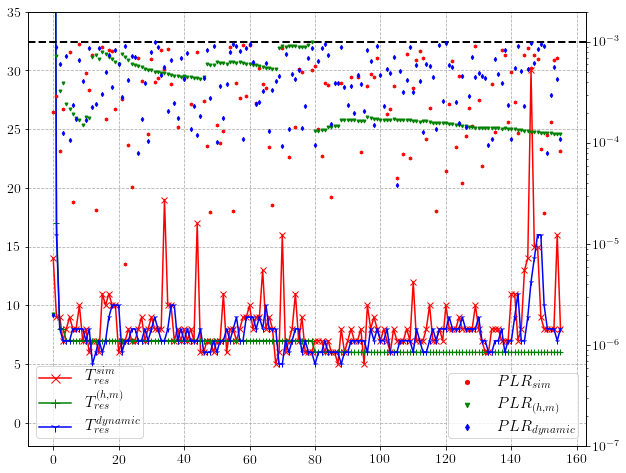

In [172]:
%matplotlib inline
plt.figure(figsize=(10, 8))
ax = plt.gca()
ax.plot(sim_opt_res_periods, label='$T_{res}^{sim}$', color='r', marker='x')
ax.plot(hm_ana_opt_res_periods, label='$T_{res}^{(h, m)}$', color='g', marker='+')
ax.plot(dym_opt_res_periods, label='$T_{res}^{dynamic}$', color='b', marker='1')
ax.legend(loc=0)
ax.set_ylim([-2, 35])

ax2 = ax.twinx()
ax2.axhline(y=PLRQoS, xmin=0, xmax=len(hm_ana_plrs), linestyle='--', linewidth=2, color='k')
ax2.plot(new_sim_plrs, label=r'$PLR_{sim}$', linestyle='none', marker='h', color='r',  ms=3)
ax2.plot(hm_ana_plrs, label=r'$PLR_{(h,m)}$', linestyle='none', marker='v', color='g',  ms=3)
ax2.plot(dyn_plrs, label=r'$PLR_{dynamic}$', linestyle='none', marker='d', color='b',  ms=3)
ax2.set_yscale('log')
ax2.legend(loc=4)
ax2.set_ylim([1e-7, 2e-3])
ax.grid(linestyle='--')
plt.savefig('dallas.pdf', format='pdf')

<a id='tracing_casino'></a>
## 3.2  Casino<sup>[head](#head)</sup>

In [43]:
results = RESULTS['Casino']
results['SIM'] = defaultdict(list)
results['BASE_TRACER'] = defaultdict(list)
results['DYN_HM'] = defaultdict(list)
results['DYN_TRACER'] = defaultdict(list)

In [44]:
results = RESULTS['Casino']
trace_filename = 'Casino.batch.dat'
trace = pd.read_csv(trace_filename, header=None).values.flatten()
per = 0.3
delay_bound = 1000
PLRQoS = 1e-3
res_period = 80
arr_period = 400
n_batches = 50
n_runs = 50
alpha = 0.99
window_size = n_batches * arr_period

parameters = {}
# Общие параметры
parameters["res_period"] = res_period
parameters["arr_period"] = arr_period
parameters['trace'] = trace
parameters["delay_bound"] = delay_bound

h_init, m_init, n_init = 0, trace[0], 0
parameters['h_init'] = h_init
parameters['m_init'] = m_init
parameters['n_init'] = n_init

# Параметры аналитики
parameters['input_distr'] = None
parameters['per'] = per

# Параметры имитации
parameters['input_file'] = 'input.txt'
parameters['trace_file'] = 'trace.txt'
parameters['model_file'] = './a.out'
parameters["max_batch_size"] = np.max(trace)

# Случайный доступ
parameters["det_per"] = per
parameters["ran_per"] = 1.0
parameters['rand_tx_duration'] = 200000
parameters['det_tx_duration'] = 100000
parameters['mean_access_time'] = 100000
parameters['random_on'] = 0
res_periods = np.arange(5, 101, 1)

In [46]:
for n_window in range(40):
    print('STARTING AT {}'.format((h_init, m_init, n_init)))
    # Запуск имитации 
    for label in ['BASE_TRACER', 'DYN_HM', 'DYN_TRACER']:
        plr_calculator = PLR_CALCULATORS[label](parameters=parameters, 
                                               window_size=window_size, 
                                               n_runs=n_runs,
                                               return_params=False, 
                                               alpha=alpha)
        print('\t{} BINSEARCH'.format(label))
        # Нахождение предполагаемого оптимального Tres-а
        opt_res_period, expected_plr = find_best_res_period(res_periods, plr_calculator, PLRQoS)
        results[label]['opt_res_periods'].append(opt_res_period)
        results[label]['expected_plrs'].append(expected_plr)
        
        # Нахождение фактического PLR-а для оптимального Tres-а
        plr_calculator = PLR_CALCULATORS['BASE_TRACER'](parameters=parameters, window_size=window_size)
        real_plr = plr_calculator(opt_res_period)
        results[label]['real_plrs'].append(real_plr)
        print('\t[{}] (expected) PLR[{}] = {}, (real) PLR[{}] = {}'.format(
            label, opt_res_period, expected_plr, opt_res_period, real_plr))
    
    opt_res_period = results['DYN_TRACER']['opt_res_periods'][-1]
    plr_calculator = PLR_CALCULATORS['SIM'](parameters=parameters,
                                            window_size=window_size,
                                            n_runs=1,
                                            return_params=True)
    sim_plr, sim_output = plr_calculator(opt_res_period)
    ana_plr = results['DYN_HM']['expected_plrs'][-1]
    
    h_init, m_init, n_init = sim_output['h_init'], sim_output['m_init'], sim_output['n_init']
    parameters['h_init'] = h_init
    parameters['m_init'] = m_init
    parameters['n_init'] = n_init
    
    print('n_window = {}, (sim) PLR[{}] = {}, (ana) PLR[{}] = {}'.format( 
        n_window, opt_res_period, sim_plr, opt_res_period, ana_plr)) 
    print('\tfinished at {}'.format((h_init, m_init, n_init)))

STARTING AT (319, 2, 489)
	BASE_TRACER BINSEARCH
	[BASE_TRACER] (expected) PLR[18] = 0.0003366255615758572, (real) PLR[18] = 0.0003366255615758572
	DYN_HM BINSEARCH
	[DYN_HM] (expected) PLR[20] = 0.0005103441107751975, (real) PLR[20] = 0.003229762729180395
	DYN_TRACER BINSEARCH
	[DYN_TRACER] (expected) PLR[20] = 0.0004886879664211944, (real) PLR[20] = 0.003229762729180395
n_window = 0, (sim) PLR[20] = 0.00912409, (ana) PLR[20] = 0.0005103441107751975
	finished at (339, 6, 538)
STARTING AT (339, 6, 538)
	BASE_TRACER BINSEARCH
	[BASE_TRACER] (expected) PLR[27] = 0.0008128285266952228, (real) PLR[27] = 0.0008128285266952228
	DYN_HM BINSEARCH
	[DYN_HM] (expected) PLR[19] = 0.0005227285166237439, (real) PLR[19] = 0.0
	DYN_TRACER BINSEARCH
	[DYN_TRACER] (expected) PLR[19] = 0.0004897497941411739, (real) PLR[19] = 0.0
n_window = 1, (sim) PLR[19] = 0.0, (ana) PLR[19] = 0.0005227285166237439
	finished at (346, 1, 587)
STARTING AT (346, 1, 587)
	BASE_TRACER BINSEARCH
	[BASE_TRACER] (expected) PL

In [49]:
def plot_single_algorithm(label, algorithm):
    results = RESULTS[label]
    f, axarr = plt.subplots(2, sharex=True, figsize=(10, 8))
    # res_periods
    ax = axarr[0]
    res_periods = results['BASE_TRACER']['opt_res_periods']
    ax.plot(res_periods, label='$T_{res}^{sim}$', color='r', marker='x')
    res_periods = results[algorithm]['opt_res_periods']
    ax.plot(res_periods, label='$T_{res}^{alg}$', color='b', marker='+')
    ax.legend(loc=0, numpoints=1)
    ax.set_ylim([-2, 35])
    ax.set_xlim([-1, len(res_periods) + 1])
    ax.grid(linestyle='--')
    
    ax = axarr[1]
    plrs = results[algorithm]['expected_plrs']
    ax.axhline(y=PLRQoS, xmin=0, xmax=len(plrs), linestyle='--', linewidth=2, color='k')
    ax.plot(plrs, label=r'$PLR_{exp alg}$', linestyle='none', marker='d', color='b',  ms=6)
    plrs = results[algorithm]['real_plrs']
    ax.plot(plrs, label=r'$PLR_{real alg}$', linestyle='none', marker='o', color='b',  ms=6)
    plrs = results['BASE_TRACER']['expected_plrs']
    ax.plot(plrs, label=r'$PLR_{exp sim}$', linestyle='none', marker='v', color='r',  ms=6)
    ax.set_ylim([1e-7, 1e-0])
    ax.set_yscale('log')
    ax.legend(loc=4, numpoints=1)
    ax.grid(linestyle='--')
    plt.savefig('{}.pdf'.format(label), format='pdf')

In [38]:
pkl.dump(RESULTS, open('RESULTS_200.pkl', 'wb'))

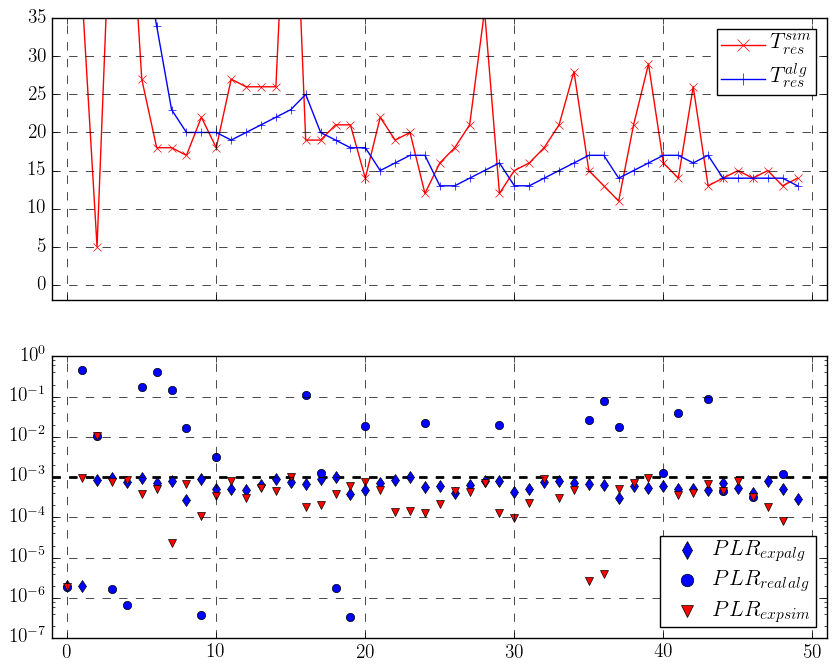

In [50]:
plot_single_algorithm('Casino', 'DYN_HM')

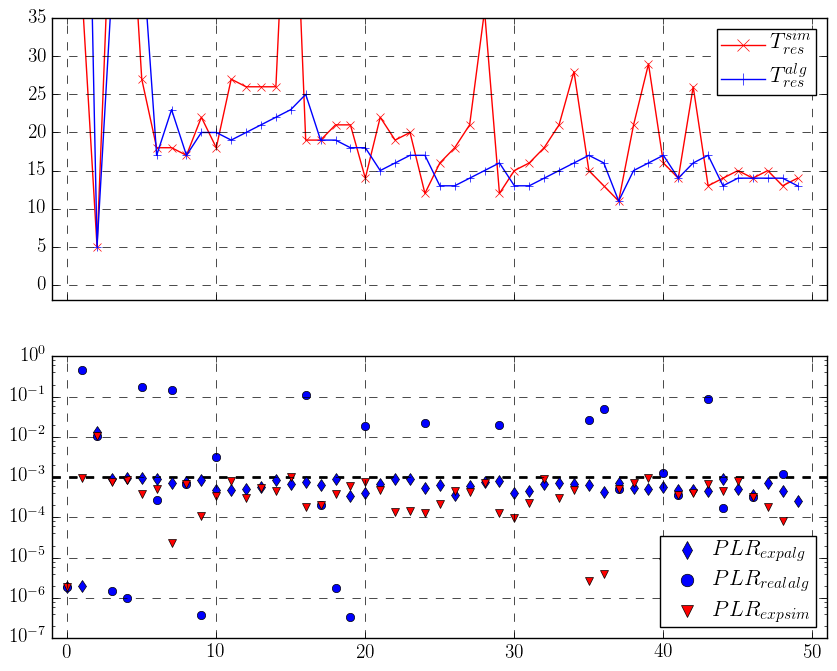

In [51]:
plot_single_algorithm('Casino', 'DYN_TRACER')